In [1]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore
from tensorflow import keras

In [2]:
# Constants
# batch size for model
BATCH_SIZE = 100
# number of epochs
EPOCHS = 50
# proportion of validation data
VALIDATION_SPLIT = 0.2
# learning rate and epsilon for ADAM optimizer
LEARNING_RATE = 0.01
EPSILON = 1
# path where data is stored
PATH="/Users/tanvipotdar/Projects/thesis/data/INTC_2015-01-01_2015-01-31_10"
# prediction horizon
K = 10 
# threshold to decide which category midprice direction falls in (up, down, stationary)
ALPHA = 0.001

# Static objects
# instantiate one hot encoder here so that all classes will always map to the same labels
onehot_encoder = OneHotEncoder(sparse=False)

## Prepare the data

In [3]:
def get_data(path, num_files_to_choose=np.inf):
    all_files = glob.glob(path + "/*orderbook_10.csv")
    all_files.sort()
    i = min(num_files_to_choose, len(all_files))
    orderbooks = []
    for filename in all_files[:i]:
        df = pd.read_csv(filename, index_col=None, header=None)
        orderbooks.append(df)
    orderbook = pd.concat(orderbooks, axis=0, ignore_index=True)
    col_names = ['ask_price_', 'ask_size_', 'bid_price_', 'bid_size_']
    nums = map(str, range(1,11))
    orderbook.columns = [y + x for x in nums for y in col_names]
    return orderbook
data = get_data(path=PATH, num_files_to_choose=3)
data.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,367300,4000,365200,400,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
1,367300,4000,365200,400,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
2,367300,4000,365200,100,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
3,367300,4000,365200,100,367500,200,364800,300,367900,300,...,362900,200,372900,1000,361800,200,373400,2500,361500,200
4,367300,4000,365200,100,367500,200,364800,300,367900,300,...,362900,200,372900,1000,361800,200,373400,2500,361500,200


In [4]:
def normalise_data(data):
    normalised_data = data.apply(zscore)
    return normalised_data
normalised_data = normalise_data(data)
normalised_data.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,1.641743,-0.076267,1.171577,-0.753204,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.529661,-0.579836,2.781734,-0.951862,0.482117,-0.62744,2.876673,-0.219309,0.339465,-0.559228
1,1.641743,-0.076267,1.171577,-0.753204,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.529661,-0.579836,2.781734,-0.951862,0.482117,-0.62744,2.876673,-0.219309,0.339465,-0.559228
2,1.641743,-0.076267,1.171577,-0.813901,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.529661,-0.579836,2.781734,-0.951862,0.482117,-0.62744,2.876673,-0.219309,0.339465,-0.559228
3,1.641743,-0.076267,1.171577,-0.813901,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.791232,-0.579836,2.781734,-0.951862,0.553455,-0.62744,2.876673,-0.219309,0.505915,-0.559228
4,1.641743,-0.076267,1.171577,-0.813901,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.791232,-0.579836,2.781734,-0.951862,0.553455,-0.62744,2.876673,-0.219309,0.505915,-0.559228


In [5]:
# smoothed labelling of the midprice/ K is the prediction horizon
def smooth_midprice_using_k_lookahead(normalised_data, k):
    normalised_data['midprice'] = (normalised_data.ask_price_1+normalised_data.bid_price_1)/2
    # mean of previous k mid-prices
    normalised_data['m_minus'] = normalised_data['midprice'].rolling(window=k).mean()
    # mean of next k mid-prices
    normalised_data['m_plus'] = normalised_data['midprice'][::-1].rolling(window=k).mean()[::-1]
    return normalised_data
normalised_data = smooth_midprice_using_k_lookahead(normalised_data, k=K)

In [6]:
# label the smoothed mid-prices based on a threshold/ ALPHA is the threshold 
def create_midprice_labels(normalised_data):
    normalised_data['change'] = (normalised_data.m_plus - normalised_data.m_minus)/normalised_data.m_minus
    # assign categories up, down, stationary
    normalised_data['label'] = pd.cut(normalised_data.change, bins=[-np.inf, -ALPHA, ALPHA, np.inf], 
                                    labels=['down', 'stationary', 'up'])
    # drop all unlabelled values (will be first and last k values as they have no m_minus/m_plus value)
    normalised_data.dropna(inplace=True)
    return normalised_data
normalised_data = create_midprice_labels(normalised_data)

In [7]:
# split into train and test data
N = len(normalised_data) - len(normalised_data)%100
def reshape_and_categorise_data(normalised_data, n):
    data = normalised_data[:n]
    cols = data.columns.to_list()[:40]
    input_data = data[cols]
    input_array = input_data.to_numpy().reshape(n//100,100,40,1)

    output_data = data.label.to_numpy()[::-100][::-1]
    integer_encoded = output_data.reshape(len(output_data), 1)
    output_array = onehot_encoder.fit_transform(integer_encoded)
    X_train, X_test, y_train, y_test = train_test_split(input_array, output_array, shuffle=False)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = reshape_and_categorise_data(normalised_data, N)
print("Training input shape:",X_train.shape)
print("Test input shape:", X_test.shape)
print("Training output shape:", y_train.shape)
print("Test input shape:", y_test.shape)

Training input shape: (23017, 100, 40, 1)
Test input shape: (7673, 100, 40, 1)
Training output shape: (23017, 3)
Test input shape: (7673, 3)


In [8]:
# mapping of labels to one hot encoding
encodings = [[1,0,0],[0,0,1],[0,1,0]]
onehot_encoder.inverse_transform([encodings[0]]).tolist()[0][0]
mapping = {np.argmax(key):onehot_encoder.inverse_transform([key]).tolist()[0][0] for key in encodings}
print(mapping)

{0: 'down', 2: 'up', 1: 'stationary'}


## Build and compile the model

In [18]:
def create_model():
    # convolutional layers
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(16, kernel_size=(4, 40), strides=(1, 1),data_format='channels_last',activation='relu',
                     input_shape=(100,40,1)))
    model.add(keras.layers.Conv2D(16, kernel_size=(1,1),strides=(1,1),data_format='channels_last',activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,1), strides=2))
    model.add(keras.layers.Conv2D(32,kernel_size=(4,1), strides=(1,1),data_format='channels_last',activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,1), strides=2))
    model.add(keras.layers.Conv2D(32,kernel_size=(3,1), strides=(1,1),data_format='channels_last',activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,1), strides=2))
    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
    model.add(keras.layers.LSTM(100,kernel_regularizer=keras.regularizers.l2(0.01),return_sequences=False,activation='relu'))
    #model.add(BatchNormalization(momentum=0.9))
    model.add(keras.layers.Dropout(0.20))
    model.add(keras.layers.Dense(3, activation='softmax'))

    # compile model and summarize
    adam = keras.optimizers.Adam(lr=0.01, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
model = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 97, 1, 16)         2576      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 97, 1, 16)         272       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 94, 1, 32)         2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 1, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 45, 1, 32)         3104      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 1, 32)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 22, 32)            0         
__________

In [19]:
def fit_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Batch size:{}, K:{}".format(BATCH_SIZE, K))
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)
    score, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print("Accuracy is {}%".format(accuracy*100))
    return accuracy*100, history
accuracy, history = fit_and_evaluate_model(model, X_train, X_test, y_train, y_test)

Batch size:100, K:10
Train on 18413 samples, validate on 4604 samples
Epoch 1/50
18413/18413 [==============================] - 18s 968us/sample - loss: 1.5367 - acc: 0.8216 - val_loss: 1.3857 - val_acc: 0.8792
Epoch 2/50
18413/18413 [==============================] - 16s 876us/sample - loss: 1.1502 - acc: 0.8673 - val_loss: 1.1788 - val_acc: 0.8792
Epoch 3/50
18413/18413 [==============================] - 16s 875us/sample - loss: 1.0628 - acc: 0.8673 - val_loss: 1.0881 - val_acc: 0.8792
Epoch 4/50
18413/18413 [==============================] - 16s 882us/sample - loss: 1.0206 - acc: 0.8673 - val_loss: 1.0339 - val_acc: 0.8792
Epoch 5/50
18413/18413 [==============================] - 17s 899us/sample - loss: 0.9861 - acc: 0.8673 - val_loss: 0.9869 - val_acc: 0.8792
Epoch 6/50
18413/18413 [==============================] - 15s 826us/sample - loss: 0.9539 - acc: 0.8672 - val_loss: 0.9528 - val_acc: 0.8792
Epoch 7/50
18413/18413 [==============================] - 16s 850us/sample - loss: 0

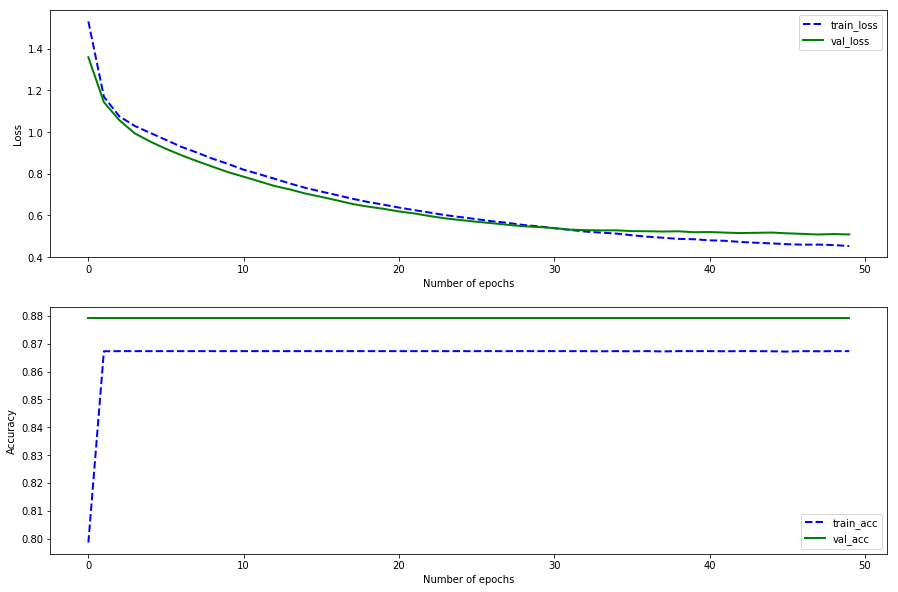

In [16]:
def plots(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
    plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
    plt.legend()
    # plt.ylim([.5,1.3])
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.subplot(2,1,2)
    plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
    plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
    plt.legend()
    # plt.ylim([.2,1.0])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.show()
plots(history)

## Evaluate performance

In [17]:
def get_report(model, X_test, y_test, X_train, y_train):
    target_names = [mapping[i] for i in range(3)]
    y_pred = model.predict(X_test)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = np.argmax(y_test, axis=1)
    print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
    print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))
get_report(model, X_test, y_test, X_train, y_train)

              precision    recall  f1-score   support

        down       0.00      0.00      0.00         0
  stationary       1.00      0.88      0.94      7673
          up       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88      7673
   macro avg       0.33      0.29      0.31      7673
weighted avg       1.00      0.88      0.94      7673

[[   0  427    0]
 [   0 6766    0]
 [   0  480    0]]
